# ERP Simulations

In [2]:
###
# Helper functions #
###


def smoothn(X,width=5, kernel='uniform',
            remove_edges = False):
    """ 
    apply a smoothing kernel along axis 0.
    width: integer specifying number of samples in smoothing window
    kernel: 'uniform', 'gauss', or 1D-array
    remove_edges: replace NaN for edge values (makes no assumptions)
    """ 
    KERNELS = {
      'uniform':   lambda w: np.ones((int(w)))/w,
      'gauss':  lambda w: gauss_kern( w )
    }
    if type(kernel) == str:
      k = KERNELS[kernel](width)
    else:
      k = kernel
      width = len(k) # ignore width parameter 
    shp = X.shape
    x2 = X.copy().reshape(X.shape[0],-1)
    Y  = x2.copy()
    g  = x2.copy()
    goodness = ~np.isnan(x2)
    x2[np.isnan(x2)] = 0 # trick the algorithm into ignoring nans
    for i in range(x2.shape[1]):
      # the trick here is to do a second convolution on a 0/1 array to 
      # find out how many valid data points there were, and normalise by this
      Y[:,i] = np.convolve( x2[:,i],       k, mode='same' )
      g[:,i] = np.convolve( goodness[:,i], k,  mode='same')
    if remove_edges:
      Y[0:width,:] = np.nan
      Y[-width:,:] = np.nan
    Y = Y / g
    Y[ g==0 ] = np.nan
    Y = Y.reshape(shp)
    return Y

def gauss_kern(N=10,S=0.4):
  """
  n-D Gaussian kernel, 
   * N = width of kernel - either a single integer, or a list / tuple
         with one value per dimension. e.g.  N=(10,10) gives a 10 x 10 kernel.
   * S = standard deviation S (as a proportion of the width).
         defaults to 0.4. Can be specified for each dimension separately.
  Values are normalised to add up to 1
  if S defaults to 1/3 of the width.
  """
  if not hasattr(N,"__len__"): # check if N is a scalar
    N=(N,)
  if not hasattr(S,"__len__"): # if S is scalar, use it for every dimension
    S = [S] * len(N)
  from scipy.stats import norm
  xs = []
  for i,n in enumerate(N):
    dims = [ 1 ] * len(N)
    dims[i] = n
    support = np.linspace(-1,1,n) / S[i] # 1-dimensional support array
    pdf = norm.pdf( support ) # convert to probabliity
    xs.append(  pdf.reshape(dims) ) #
  import math
  p = math.prod(xs)  # not the numpy prod, which will multiply every inner element!
  p = p / np.sum(p)
  return p

## Simulation 15: ERP simulation when there is a break in syntax

In [48]:
import random
import numpy as np
from copy import deepcopy
from importlib import reload 

import sanjay_replication_o as sr ## Our model
import syntactic_wm as cjn
reload(sr)
reload(cjn)


################
## Parameters ##
################
num_steps = 50 # number of time steps taken by each word input.
head = 1 # number of time steps buffering the front of each sentence.
tail = 20 # number of time steps buffering the end of each sentence.
no_periods = 1 # number of epochs each sentence is presented to the model.

lambda_cc = 50 # learning rate of short-term synaptic plasticity amongst role neurons.
lambda_cf = 1 # learning rate of short-term synaptic plasticity between role and word neurons.

tau = 0.5 # modifies change in firing rate at each time step to simulate continuous time.

beta = 1 # decay factor of firing rates.

n_word_neurons = 15 # number of word neurons initialised (f)
n_role_neurons = 10 # number of role neurons initialised (c)

gamma = 1 # factor dampening connectivity amongst role neurons.

k_cc = 4 # negative bias, i.e. negative k_cc is the floor of c-c connections.
epsilon_cc = 0.75 # the ceiling of c-c connections when without long-term encoding. 

k_cf = 1 # negative bias, i.e. negative k_cf is the floor of c-f connections.
epsilon_cf = 1.5 # the ceiling of c-f connections when without long-term encoding. 

h = 2 # normalising factor for inhibition between c-f connections.

W_mc = 0 # connectivity between morph and role neurons (non-encodable)
W_mm = 0 # conneectivity between morpheme neurons to itself (non-encodable)

W_ff = -1.5  # connectivity amongst word neurons (non-encodable)

unified_noise = 0.5 # noise level if noise is present
cc_noise = True # any noise amongst role neurons
wc_noise = True # any noise between role and word neurons

k_L_cc = 4.5 # long-term encoding amongst role neurons 
k_L_cf = 1.7 # long-term encoding between role and word neurons

# also note that seed will not have an effect on recall unless noise is added to the network.
seed_ = 0 # setting default random seed
np.random.seed(seed_)
random.seed(seed_)

In [49]:
## define sentences
LT_wc_knowledge = [[0,0],[1,1],[2,1],[3,1],[4,2],[5,3],[1,4],[2,4],[3,4]] # word to role connections with long-term encoding
LT_cc_knowledge = [[0,1,2,3,4]] # sequence of role to role connections with long-term encoding
unified_noise = 0.5 #0.2 # noise level if noise is present
cc_noise = True # any noise amongst role neurons
wc_noise = True # any noise between role and word neurons

normal_0 = []
for n in range(head): normal_0.append(cjn.in_in())
for n in range(num_steps): normal_0.append(cjn.in_in(word=0))
for n in range(num_steps): normal_0.append(cjn.in_in(word=1))
for n in range(num_steps): normal_0.append(cjn.in_in(word=4))
for n in range(num_steps): normal_0.append(cjn.in_in(word=5))
for n in range(num_steps): normal_0.append(cjn.in_in(word=2))
for n in range(tail): normal_0.append(cjn.in_in())

normal_1 = []
for n in range(head): normal_1.append(cjn.in_in())
for n in range(num_steps): normal_1.append(cjn.in_in(word=0))
for n in range(num_steps): normal_1.append(cjn.in_in(word=2))
for n in range(num_steps): normal_1.append(cjn.in_in(word=4))
for n in range(num_steps): normal_1.append(cjn.in_in(word=5))
for n in range(num_steps): normal_1.append(cjn.in_in(word=1))
for n in range(tail): normal_1.append(cjn.in_in())

normal_2 = []
for n in range(head): normal_2.append(cjn.in_in())
for n in range(num_steps): normal_2.append(cjn.in_in(word=0))
for n in range(num_steps): normal_2.append(cjn.in_in(word=1))
for n in range(num_steps): normal_2.append(cjn.in_in(word=4))
for n in range(num_steps): normal_2.append(cjn.in_in(word=5))
for n in range(num_steps): normal_2.append(cjn.in_in(word=3))
for n in range(tail): normal_2.append(cjn.in_in())

normal_3 = []
for n in range(head): normal_3.append(cjn.in_in())
for n in range(num_steps): normal_3.append(cjn.in_in(word=0))
for n in range(num_steps): normal_3.append(cjn.in_in(word=3))
for n in range(num_steps): normal_3.append(cjn.in_in(word=4))
for n in range(num_steps): normal_3.append(cjn.in_in(word=5))
for n in range(num_steps): normal_3.append(cjn.in_in(word=1))
for n in range(tail): normal_3.append(cjn.in_in())

normal_4 = []
for n in range(head): normal_4.append(cjn.in_in())
for n in range(num_steps): normal_4.append(cjn.in_in(word=0))
for n in range(num_steps): normal_4.append(cjn.in_in(word=2))
for n in range(num_steps): normal_4.append(cjn.in_in(word=4))
for n in range(num_steps): normal_4.append(cjn.in_in(word=5))
for n in range(num_steps): normal_4.append(cjn.in_in(word=3))
for n in range(tail): normal_4.append(cjn.in_in())

normal_5 = []
for n in range(head): normal_5.append(cjn.in_in())
for n in range(num_steps): normal_5.append(cjn.in_in(word=0))
for n in range(num_steps): normal_5.append(cjn.in_in(word=3))
for n in range(num_steps): normal_5.append(cjn.in_in(word=4))
for n in range(num_steps): normal_5.append(cjn.in_in(word=5))
for n in range(num_steps): normal_5.append(cjn.in_in(word=2))
for n in range(tail): normal_5.append(cjn.in_in())


synviol_0 = []
for n in range(head): synviol_0.append(cjn.in_in())
for n in range(num_steps): synviol_0.append(cjn.in_in(word=0))
for n in range(num_steps): synviol_0.append(cjn.in_in(word=1))
for n in range(num_steps): synviol_0.append(cjn.in_in(word=4))
for n in range(num_steps): synviol_0.append(cjn.in_in(word=2))
for n in range(num_steps): synviol_0.append(cjn.in_in(word=5))
for n in range(tail): synviol_0.append(cjn.in_in())

synviol_1 = []
for n in range(head): synviol_1.append(cjn.in_in())
for n in range(num_steps): synviol_1.append(cjn.in_in(word=0))
for n in range(num_steps): synviol_1.append(cjn.in_in(word=2))
for n in range(num_steps): synviol_1.append(cjn.in_in(word=4))
for n in range(num_steps): synviol_1.append(cjn.in_in(word=1))
for n in range(num_steps): synviol_1.append(cjn.in_in(word=5))
for n in range(tail): synviol_1.append(cjn.in_in())

synviol_2 = []
for n in range(head): synviol_2.append(cjn.in_in())
for n in range(num_steps): synviol_2.append(cjn.in_in(word=0))
for n in range(num_steps): synviol_2.append(cjn.in_in(word=1))
for n in range(num_steps): synviol_2.append(cjn.in_in(word=4))
for n in range(num_steps): synviol_2.append(cjn.in_in(word=3))
for n in range(num_steps): synviol_2.append(cjn.in_in(word=5))
for n in range(tail): synviol_2.append(cjn.in_in())

synviol_3 = []
for n in range(head): synviol_3.append(cjn.in_in())
for n in range(num_steps): synviol_3.append(cjn.in_in(word=0))
for n in range(num_steps): synviol_3.append(cjn.in_in(word=3))
for n in range(num_steps): synviol_3.append(cjn.in_in(word=4))
for n in range(num_steps): synviol_3.append(cjn.in_in(word=1))
for n in range(num_steps): synviol_3.append(cjn.in_in(word=5))
for n in range(tail): synviol_3.append(cjn.in_in())

synviol_4 = []
for n in range(head): synviol_4.append(cjn.in_in())
for n in range(num_steps): synviol_4.append(cjn.in_in(word=0))
for n in range(num_steps): synviol_4.append(cjn.in_in(word=2))
for n in range(num_steps): synviol_4.append(cjn.in_in(word=4))
for n in range(num_steps): synviol_4.append(cjn.in_in(word=3))
for n in range(num_steps): synviol_4.append(cjn.in_in(word=5))
for n in range(tail): synviol_4.append(cjn.in_in())

synviol_5 = []
for n in range(head): synviol_5.append(cjn.in_in())
for n in range(num_steps): synviol_5.append(cjn.in_in(word=0))
for n in range(num_steps): synviol_5.append(cjn.in_in(word=3))
for n in range(num_steps): synviol_5.append(cjn.in_in(word=4))
for n in range(num_steps): synviol_5.append(cjn.in_in(word=2))
for n in range(num_steps): synviol_5.append(cjn.in_in(word=5))
for n in range(tail): synviol_5.append(cjn.in_in())

all_normal = [normal_0,normal_1,normal_2,normal_3,normal_4,normal_5]
all_synviol = [synviol_0,synviol_1,synviol_2,synviol_3,synviol_4,synviol_5]


In [2]:
all_normal_act = np.zeros((60,270)) # 70 timesteps
all_synviol_act = np.zeros((60,270))
smt=30

for seed_ in range(6):
    for s in range(10):
        np.random.seed(seed_*10+s)
        random.seed(seed_*10+s)
        
        sentence = all_normal[seed_]
        
        WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc,
                       cf_max_connection = epsilon_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm
                      )


        # running the encoding phase
        role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)
        c_act_hx = c_act_hx.squeeze()
        aa = (c_act_hx**2) .sum(axis=1)
        f_act_hx = f_act_hx.squeeze()
        aa += (f_act_hx.squeeze()**2) .sum(axis=1)
        aa = smoothn(aa, smt,kernel='gauss')
        aa = np.diff(aa)
        aa = np.r_[np.nan*np.ones(15), aa[:-15]]
        all_normal_act[seed_*10+s,:] = aa

        
for seed_ in range(6):
    for s in range(10):
        np.random.seed(seed_*10+s)
        random.seed(seed_*10+s)
        
        sentence = all_synviol[seed_]
        
        WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc,
                       cf_max_connection = epsilon_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm
                      )


        # running the encoding phase
        role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)
        c_act_hx = c_act_hx.squeeze()
        aa = (c_act_hx**2) .sum(axis=1)
        f_act_hx = f_act_hx.squeeze()
        aa += (f_act_hx.squeeze()**2) .sum(axis=1)
        aa = smoothn(aa, smt,kernel='gauss')
        aa = np.diff(aa)
        aa = np.r_[np.nan*np.ones(15), aa[:-15]]
        all_synviol_act[seed_*10+s,:] = aa
        
        

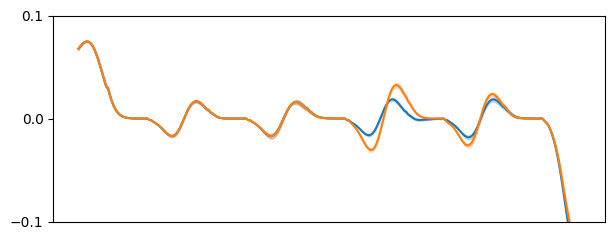

In [51]:
import matplotlib.pyplot as plt
import scipy.stats as st

a4_dims = (5*1.25, 2.5)
fig, ax = plt.subplots(figsize=a4_dims)

n_sem = st.sem(all_normal_act,axis=0)
s_sem = st.sem(all_synviol_act,axis=0)

n_avg = np.average(all_normal_act,axis=0)
s_avg = np.average(all_synviol_act,axis=0)

plt.plot(n_avg) # blue
plt.fill_between(np.array(range(0,270)), n_avg - n_sem, n_avg + n_sem, color='#1f77b4', alpha=0.2)
 
plt.plot(np.average(all_synviol_act,axis=0))
plt.fill_between(np.array(range(0,270)), s_avg - s_sem, s_avg + s_sem, color='#ff7f0e', alpha=0.2)

ax.set(ylim=(-0.1,0.1))
ax.set_yticks([-0.1,0,0.1])

ax.set_xticks([])
ax.set(xlabel=None,ylabel=None)

plt.tight_layout()
plt.savefig(fname='retrieving', transparent = True)

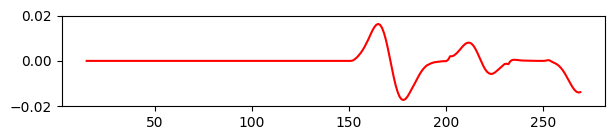

In [52]:
a4_dims = (5*1.25, 1.5)
fig, ax = plt.subplots(figsize=a4_dims)
plt.plot(n_avg-s_avg,color='r')

ax.set(ylim=(-0.02,0.02))
ax.set_yticks([-0.02,0,0.02])

plt.tight_layout()
plt.savefig(fname='retrieving', transparent = True)

## Simulation 16: ERP simulation when there is incorrect grammatical agreement

In [40]:
import random
import numpy as np
from copy import deepcopy
from importlib import reload 

import syntactic_wm as cjn ## Our model
reload(cjn)

################
## Parameters ##
################
num_steps = 50 # number of time steps taken by each word input.
head = 1 # number of time steps buffering the front of each sentence.
tail = 20 # number of time steps buffering the end of each sentence.
no_periods = 1 # number of epochs each sentence is presented to the model.

lambda_cc = 50 # learning rate of short-term synaptic plasticity amongst role neurons.
lambda_cf = 1 # learning rate of short-term synaptic plasticity between role and word neurons.

tau = 0.5 # modifies change in firing rate at each time step to simulate continuous time.

beta = 1 # decay factor of firing rates.

n_word_neurons = 15 # number of word neurons initialised (f)
n_role_neurons = 10 # number of role neurons initialised (c)

gamma = 1 # factor dampening connectivity amongst role neurons.

epsilon_cc = 4 # the ceiling of c-c connections when without long-term encoding.
k_cc = 7.5 # negative bias, i.e. negative k_cc is the floor of c-c connections.

epsilon_cf = 4 # the ceiling of c-f connections when without long-term encoding. 
k_cf = 2 # negative bias, i.e. negative k_cf is the floor of c-f connections.

h = 2 # normalising factor for inhibition between c-f connections.

W_mc = 6 # connectivity between morph and role neurons (non-encodable)
W_mm = -10 # conneectivity between morpheme neurons to itself (non-encodable)

W_ff = -1.5  # connectivity amongst word neurons (non-encodable)

unified_noise = 0 # noise level if noise is present
cc_noise = False # any noise amongst role neurons
wc_noise = False # any noise between role and word neurons

k_L_cc = 0 # long-term encoding amongst role neurons 
k_L_cf = 3.7 # long-term encoding between role and word neurons

auto_gramm = False

seed_ = 0 # setting default random seed
np.random.seed(seed_)
random.seed(seed_)

In [46]:
unified_noise = 2 # noise level if noise is present
cc_noise = True # any noise amongst role neurons
wc_noise = True # any noise between role and word neurons


# long-term encodings
LT_wc_knowledge = [[0,0], # the
                   [1,1], # dogs
                   [2,2], # were
                   [3,3], # hungry
                   [4,3], # adj2
                   [5,3], # adj3
                   [6,4], # beasts
                   [8,5], # eating
                   [9,6], # hungr-ily
                   [10,6], # adverb 2
                   [11,6]  # adverb 3
                  ] 
LT_cc_knowledge = [[0,1,2,3,4], #art -> noun -> adjective
                   [0,1,2,5,6]] #art -> noun -> past participle

morph_nodes = [6] # 6 is -ily



In [47]:
normal_0 = []
for n in range(head): normal_0.append(cjn.in_in())
for n in range(num_steps): normal_0.append(cjn.in_in(word=0))
for n in range(num_steps): normal_0.append(cjn.in_in(word=1))
for n in range(num_steps): normal_0.append(cjn.in_in(word=2))
for n in range(num_steps): normal_0.append(cjn.in_in(word=8))
for n in range(num_steps): normal_0.append(cjn.in_in(word=9,morpheme=6))
for n in range(tail): normal_0.append(cjn.in_in())

normal_1 = []
for n in range(head): normal_1.append(cjn.in_in())
for n in range(num_steps): normal_1.append(cjn.in_in(word=0))
for n in range(num_steps): normal_1.append(cjn.in_in(word=1))
for n in range(num_steps): normal_1.append(cjn.in_in(word=2))
for n in range(num_steps): normal_1.append(cjn.in_in(word=8))
for n in range(num_steps): normal_1.append(cjn.in_in(word=10,morpheme=6))
for n in range(tail): normal_1.append(cjn.in_in())

normal_2 = []
for n in range(head): normal_2.append(cjn.in_in())
for n in range(num_steps): normal_2.append(cjn.in_in(word=0))
for n in range(num_steps): normal_2.append(cjn.in_in(word=1))
for n in range(num_steps): normal_2.append(cjn.in_in(word=2))
for n in range(num_steps): normal_2.append(cjn.in_in(word=8))
for n in range(num_steps): normal_2.append(cjn.in_in(word=11,morpheme=6))
for n in range(tail): normal_2.append(cjn.in_in())


syndisagree_0 = []
for n in range(head): syndisagree_0.append(cjn.in_in())
for n in range(num_steps): syndisagree_0.append(cjn.in_in(word=0))
for n in range(num_steps): syndisagree_0.append(cjn.in_in(word=1))
for n in range(num_steps): syndisagree_0.append(cjn.in_in(word=2))
for n in range(num_steps): syndisagree_0.append(cjn.in_in(word=3,morpheme=6))
for n in range(num_steps): syndisagree_0.append(cjn.in_in(word=6))
for n in range(tail): syndisagree_0.append(cjn.in_in())

syndisagree_1 = []
for n in range(head): syndisagree_1.append(cjn.in_in())
for n in range(num_steps): syndisagree_1.append(cjn.in_in(word=0))
for n in range(num_steps): syndisagree_1.append(cjn.in_in(word=1))
for n in range(num_steps): syndisagree_1.append(cjn.in_in(word=2))
for n in range(num_steps): syndisagree_1.append(cjn.in_in(word=4,morpheme=6))
for n in range(num_steps): syndisagree_1.append(cjn.in_in(word=6))
for n in range(tail): syndisagree_1.append(cjn.in_in())

syndisagree_2 = []
for n in range(head): syndisagree_2.append(cjn.in_in())
for n in range(num_steps): syndisagree_2.append(cjn.in_in(word=0))
for n in range(num_steps): syndisagree_2.append(cjn.in_in(word=1))
for n in range(num_steps): syndisagree_2.append(cjn.in_in(word=2))
for n in range(num_steps): syndisagree_2.append(cjn.in_in(word=5,morpheme=6))
for n in range(num_steps): syndisagree_2.append(cjn.in_in(word=6))
for n in range(tail): syndisagree_2.append(cjn.in_in())

all_normal = [normal_0,normal_1,normal_2]
all_syndisagree = [syndisagree_0,syndisagree_1,syndisagree_2]

********************
Epoch = 1
Number of recorded time steps:  271
********************


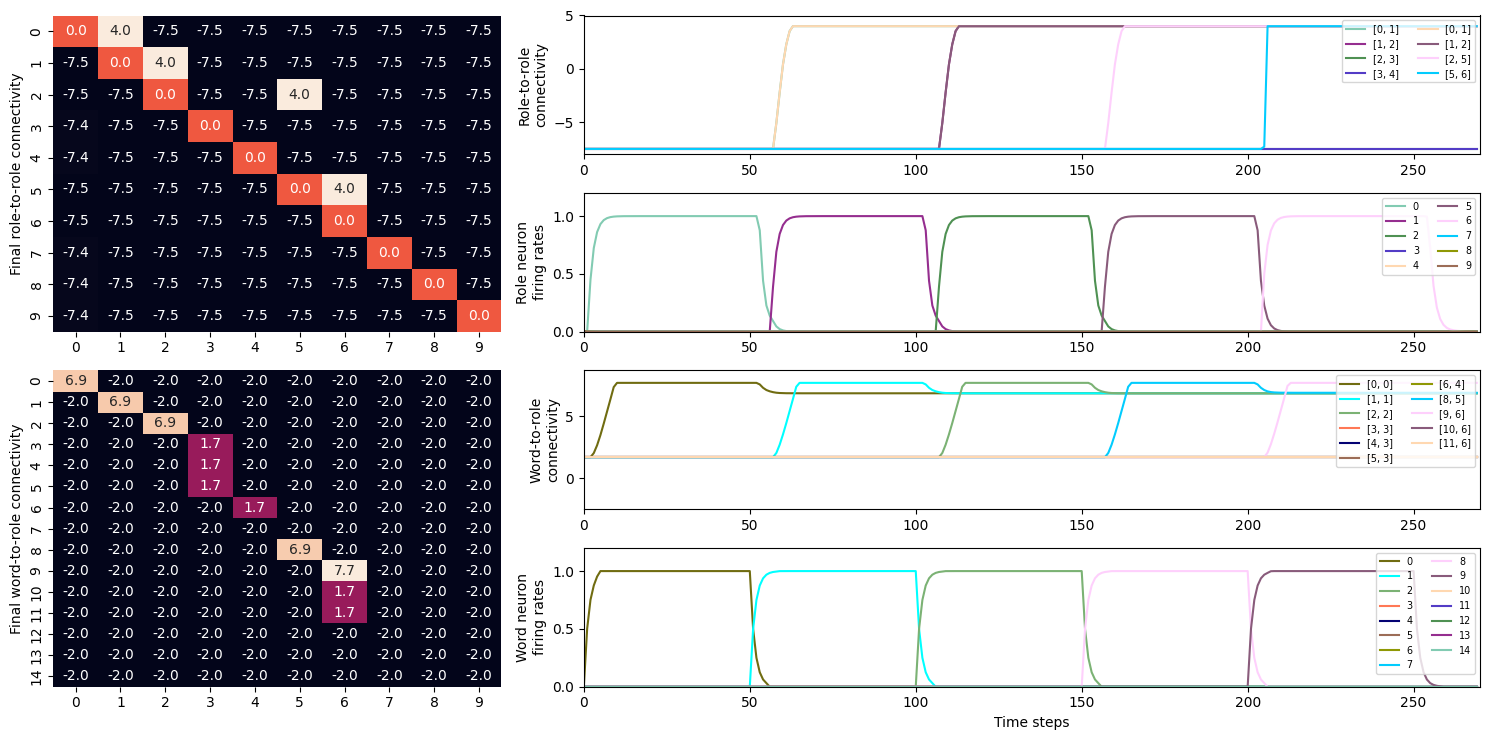

In [30]:
sentence = all_normal[0]

WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc,
                       cf_max_connection = epsilon_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       morph_nodes = morph_nodes,
                       closed_class_learnt_weight = k_L_cf_closed_class - k_cf,
                       auto_gramm = auto_gramm
                      )

# running the encoding phase
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)
        
cjn.plot_results(sentence, epsilon_cc+k_L_cc, -k_cc, epsilon_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx,no_periods=no_periods)

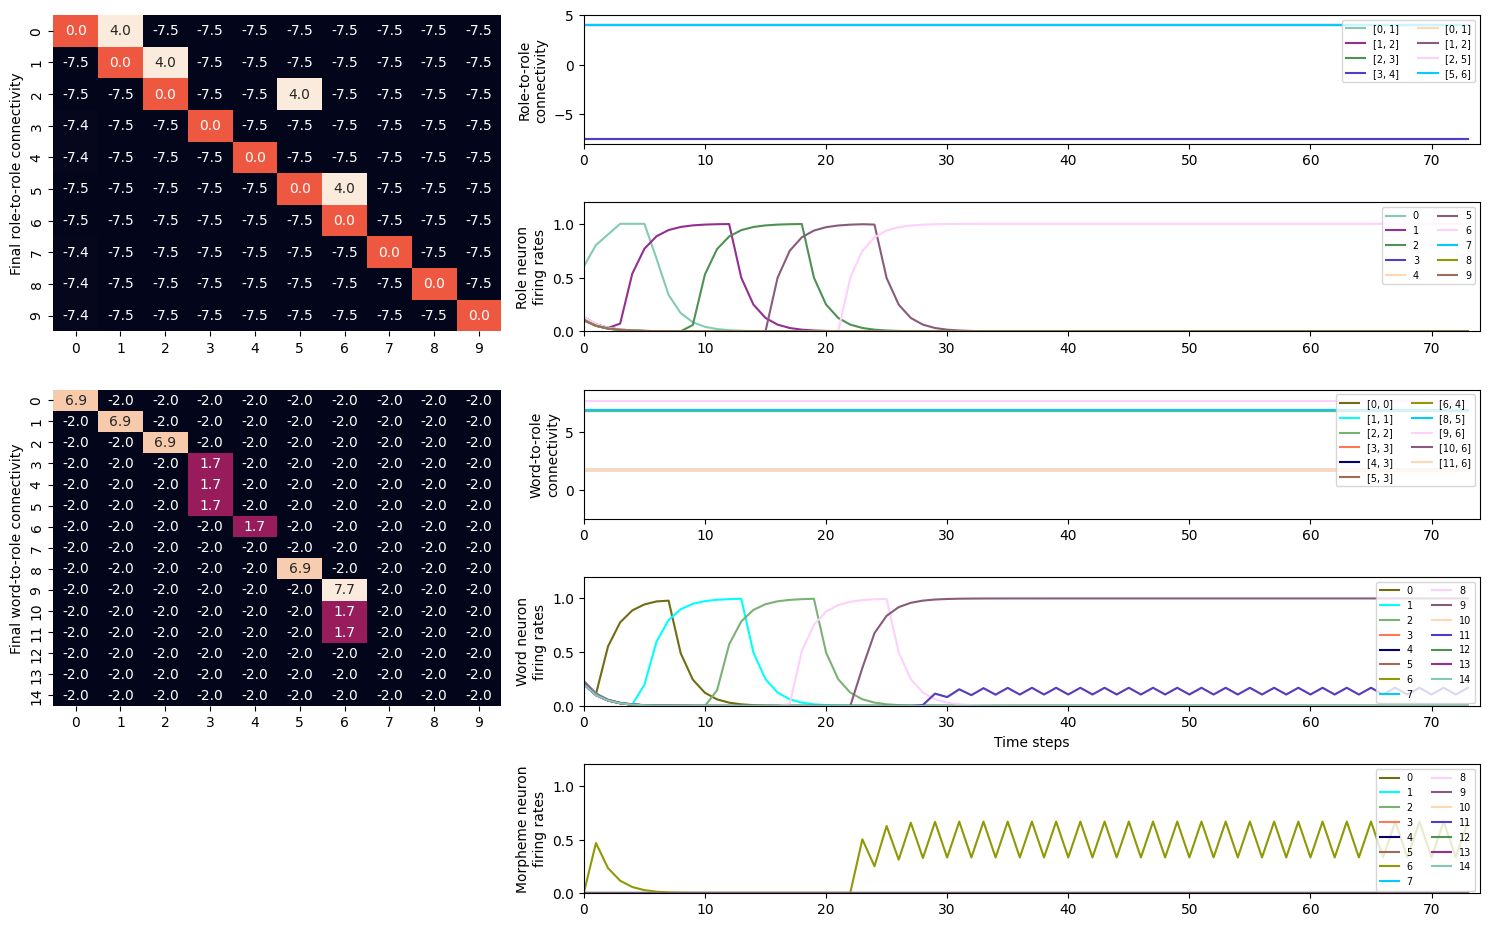

The final recall output is: 
[[0.0], [1.0], [2.0], [8.0], [9.0]]


In [31]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 75 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc+k_L_cc, -k_cc, epsilon_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r, morph_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

In [57]:
all_normal_act = np.zeros((30,270))
all_syndisagree_act = np.zeros((30,270))
smt=30

for seed_ in range(3):
    for s in range(10):
        np.random.seed(seed_*10+s)
        random.seed(seed_*10+s)
        
        sentence = all_normal[seed_]

        ## initialising the working memory model
        WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                               cc_connectivity_factor = gamma,
                               activation_decay = beta,
                               LR_c = lambda_cc,
                               LR_w = lambda_cf,
                               cc_max_connection = epsilon_cc,
                               cf_max_connection = epsilon_cf,
                               n_word_neurons = n_word_neurons,
                               time_factor = tau,
                               LT_wc_knowledge = LT_wc_knowledge,
                               cc_learnt_weight = k_L_cc - k_cc,
                               cf_learnt_weight = k_L_cf - k_cf,
                               input_node_connectivity = W_ff,
                               LT_cc_knowledge = LT_cc_knowledge,
                               cc_floor_weight = -k_cc, 
                               cf_floor_weight = -k_cf,
                               unified_noise = unified_noise,
                               cc_noise = cc_noise,
                               wc_noise = wc_noise,
                               cf_conj_factor = h,
                               mc_connectivity_factor = W_mc,
                               mm_connectivity_factor = W_mm,
                               morph_nodes = morph_nodes,
                               closed_class_learnt_weight = k_L_cf_closed_class - k_cf,
                               auto_gramm = auto_gramm
                              )

        # running the encoding phase
        role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)
        
        c_act_hx = c_act_hx.squeeze()
        aa = (c_act_hx**2).sum(axis=1)
        f_act_hx = f_act_hx.squeeze()
        aa += (f_act_hx.squeeze()**2).sum(axis=1)
        morph_act_hx = morph_act_hx.squeeze()
        aa += (morph_act_hx.squeeze()**2).sum(axis=1)
        aa = smoothn(aa, smt,kernel='gauss')
        aa = np.diff(aa)
        aa = np.r_[np.nan*np.ones(15), aa[:-15]]
        all_normal_act[seed_*10+s,:] = aa
        
for seed_ in range(3):
    for s in range(10):
        np.random.seed(seed_*10+s)
        random.seed(seed_*10+s)
        
        sentence = all_syndisagree[seed_]
        
        print(len(sentence))

        ## initialising the working memory model
        WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                               cc_connectivity_factor = gamma,
                               activation_decay = beta,
                               LR_c = lambda_cc,
                               LR_w = lambda_cf,
                               cc_max_connection = epsilon_cc,
                               cf_max_connection = epsilon_cf,
                               n_word_neurons = n_word_neurons,
                               time_factor = tau,
                               LT_wc_knowledge = LT_wc_knowledge,
                               cc_learnt_weight = k_L_cc - k_cc,
                               cf_learnt_weight = k_L_cf - k_cf,
                               input_node_connectivity = W_ff,
                               LT_cc_knowledge = LT_cc_knowledge,
                               cc_floor_weight = -k_cc, 
                               cf_floor_weight = -k_cf,
                               unified_noise = unified_noise,
                               cc_noise = cc_noise,
                               wc_noise = wc_noise,
                               cf_conj_factor = h,
                               mc_connectivity_factor = W_mc,
                               mm_connectivity_factor = W_mm,
                               morph_nodes = morph_nodes,
                               closed_class_learnt_weight = k_L_cf_closed_class - k_cf,
                               auto_gramm = auto_gramm
                              )

        # running the encoding phase
        role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)
        
        c_act_hx = c_act_hx.squeeze()
        aa = (c_act_hx**2).sum(axis=1)
        f_act_hx = f_act_hx.squeeze()
        aa += (f_act_hx.squeeze()**2).sum(axis=1)
        morph_act_hx = morph_act_hx.squeeze()
        aa += (morph_act_hx.squeeze()**2).sum(axis=1)
        aa = smoothn(aa, smt,kernel='gauss')
        aa = np.diff(aa)
        aa = np.r_[np.nan*np.ones(15), aa[:-15]]
        all_syndisagree_act[seed_*10+s,:] = aa

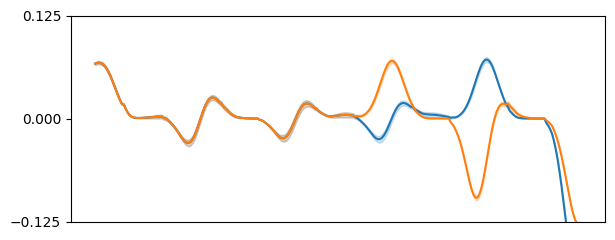

In [51]:
import matplotlib.pyplot as plt
import scipy.stats as st

a4_dims = (5*1.25, 2.5)
fig, ax = plt.subplots(figsize=a4_dims)

n_sem = st.sem(all_normal_act,axis=0)
s_sem = st.sem(all_syndisagree_act,axis=0)

n_avg = np.average(all_normal_act,axis=0)
s_avg = np.average(all_syndisagree_act,axis=0)

plt.plot(n_avg) # blue
plt.fill_between(np.array(range(0,270)), n_avg - n_sem, n_avg + n_sem, color='#1f77b4', alpha=0.2)
 
plt.plot(s_avg)
plt.fill_between(np.array(range(0,270)), s_avg - s_sem, s_avg + s_sem, color='#ff7f0e', alpha=0.2)

ax.set(ylim=(-0.1,0.1))
ax.set_yticks([-0.125,0,0.125])

ax.set_xticks([])
ax.set(xlabel=None,ylabel=None)

plt.tight_layout()
plt.savefig(fname='retrieving', transparent = True)

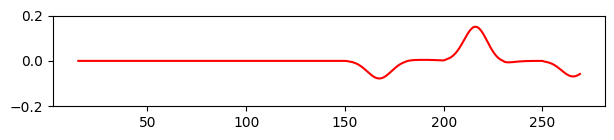

In [56]:
a4_dims = (5*1.25, 1.5)
fig, ax = plt.subplots(figsize=a4_dims)
plt.plot(n_avg-s_avg,color='r')

ax.set(ylim=(-0.1,0.1))
ax.set_yticks([-0.2,0,0.2])

ax.set_xticks([50,100,150,200,250])

plt.tight_layout()
plt.savefig(fname='retrieving', transparent = True)